## Proportional approval voting



Let's start with some simulated votes.

In [107]:
from scipy import stats
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [244]:
# a simple model for generating votes,
# where candidates and voters are normally distributed
# in multi-dimensional space, and voters vote for between
# 1 and n_cands-1 closest candidates
def create_voters(n_dims, n_voters, dist=None):
    if dist is None:
        dist = stats.norm(0, 1)
    return dist.rvs((n_voters, n_dims))

def create_cands(n_dims, n_cands, dist=None):
    if dist is None:
        dist = stats.norm(0, 1)
    return dist.rvs((n_cands, n_dims))

def create_votes(voters, cands, n_votes=None):
    n_cands = cands.shape[0]
    n_voters = voters.shape[0]
    if n_votes is None:
        n_votes = stats.randint(1, n_cands).rvs(n_voters)
    else:
        n_votes = np.ones(n_voters)*n_votes
    # get ranks of each candidate, according to each voter
    ranks = ((voters[:, None, :] - cands)**2).sum(axis=2).argsort(axis=1).argsort(axis=1)
    return ranks < n_votes[:, None]

In [245]:
voters = create_voters(2, 500)
cands = create_cands(2, 12)

In [246]:
votes = create_votes(voters, cands, 3)

In [247]:
def count_winners(votes, comb):
    return votes[:, list(comb)].sum(axis=1)

def pav(votes, n_seats):
    scores = {}
    # get the weights for any-ish number of winners, starting at 0
    weights = np.concatenate([[0],
                              (1/np.arange(1, 11)).cumsum()])
    for comb in itertools.combinations(range(votes.shape[1]),
                                       n_seats):
        winners = count_winners(votes, comb)
        score = weights[winners].sum()
        scores[comb] = score
    #print(scores)
    return max(scores, key=lambda comb: scores[comb])

Let's graph stuff!

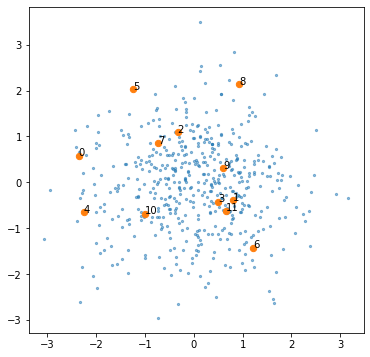

In [237]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(voters[:, 0], voters[:, 1], s=5, alpha=0.5)
ax.scatter(cands[:, 0], cands[:, 1], s=40)

for i in range(cands.shape[0]):
    ax.text(cands[i, 0], cands[i, 1], str(i))


In [243]:
pav(votes, 6)

(1, 3, 7, 9, 10, 11)